In [1]:
import os
import sys

from pathlib import Path

# Get the current working directory
cwd = Path(os.getcwd())

# Assuming your notebook is in the project root, set the project root as cwd
project_root = cwd.parent
print(project_root)

# If your notebook is in a subdirectory of the project root, you can modify the path accordingly:
# project_root = cwd.parent  # Go up one directory level
# project_root = cwd.parent.parent  # Go up two directory levels

# Add the project root directory to sys.path
sys.path.insert(0, str(project_root))
# sys.path.append('../')

import xpt.fit_analysis as xfa
import warnings
import corr_fitter.bs_utils as bs
import corr_fitter.bs_analysis as bs_analysis
import corr_fitter.load_data_priors as ld
import corr_fitter.corr_fit_analysis as fa
import xpt.priors as priors
import xpt.i_o as i_o
import xpt.fit_routine as fit
import xpt.plots as plots
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib
import tqdm
import h5py as h5
import yaml
import io
import lsqfit
import os
import importlib
import numpy as np
import gvar as gv
import pandas as pd
# from h5glance import H5Glance


warnings.simplefilter(action="default")
warnings.filterwarnings('ignore')


/home/gmoney/lqcd/hyperon-xpt-master


In [2]:
# Define paths and other variables
base_dir = "/home/gmoney/lqcd/hyperon-xpt-master"
input_dir = os.path.join(base_dir, "tests/input_files")
data_dir = os.path.join(base_dir, "data")
fit_results_dir = os.path.join(base_dir, "fit_results")
data_file = '/home/gmoney/lqcd/data/c51_2pt_octet_decuplet.h5'
hyperon_data_file = os.path.join(data_dir,"hyperon_data.h5")
bs_data_file = os.path.join(data_dir, "hyperon_bs_data.h5")
model_type = "all"
t_plot_min = 0
t_plot_max = 40
bs_N = 100
bs_seed = "seed"

In [3]:
# importlib.reload(i_o)
# input_output = i_o.InputOutput()
# data = input_output.get_data()
# print(data)
# scale_setting_data = input_output.get_scale_setting_data()

In [4]:
# import pprint
# import os.path
# fit_results = {}
# directory = fit_results_dir

# with h5.File('/home/gmoney/lqcd/data/c51_2pt_octet_decuplet.h5', "r") as f:
#     ens = sorted(list(f.keys()))
#     ens.remove('a06m310')
#     ens.remove('a09m220')
#     ens.remove('a09m220_new_old')
#     ens.remove('a09m310_new_old')
#     ens.remove('a12m130')

#     print(ens)
#     for key in ens:
#         file_path = os.path.join(directory, key, 'all', 'hyperons')
#         if os.path.isfile(file_path):
#             loaded_data = gv.load(file_path)
#             filtered_data = {}
#             for subkey, subvalue in loaded_data.items():
#                 if not isinstance(subvalue, dict):
#                     filtered_data[subkey] = subvalue
#                 else:
#                     filtered_e0_values = {k: v for k, v in subvalue.items() if '_E0' in k}
#                     if filtered_e0_values:
#                         filtered_data[subkey] = filtered_e0_values
#             fit_results[key] = filtered_data
#         else:
#             print(f"Skipping ensemble {key} because hyperons pickle file is missing.")
#             fit_results[key] = None
#     hyperons = {}
#     for abbr in ens:
#         if fit_results[abbr] is not None:
#             hyperons[abbr] = {}
#             for hyperon in ['sigma_E0', 'lam_E0', 'xi_E0', 'xi_st_E0', 'sigma_st_E0']:
#                 hyperons[abbr][hyperon] = fit_results[abbr]['p'][hyperon]
#         else:
#             print(f"Skipping {abbr} because fit_results[{abbr}] is None.")
#     pprint.pprint(hyperons)





Least Square Fit:
  chi2/dof [dof] = 1.1 [126]    Q = 0.14    logGBF = 3115.9

Parameters:
   sigma_st_z_PS 0    0.0000240 (25)       [  0.0(3.3)e-05 ]  
                 1    0.0000185 (75)       [  0.0(3.3)e-05 ]  
   sigma_st_z_SS 0      4.93(44)e-06       [ 0.000012 (12) ]  
                 1        10(12)e-07       [ 0.000012 (12) ]  
      sigma_z_PS 0   0.00002751 (61)       [  0.0(3.3)e-05 ]  
                 1     0.000031 (24)       [  0.0(3.3)e-05 ]  
      sigma_z_SS 0     4.799(97)e-06       [ 0.000012 (12) ]  
                 1        -2(19)e-07       [ 0.000012 (12) ]  *
        lam_z_PS 0   0.00002726 (53)       [  0.0(3.3)e-05 ]  
                 1     0.000031 (23)       [  0.0(3.3)e-05 ]  
        lam_z_SS 0     4.734(84)e-06       [  4.4(4.4)e-06 ]  
                 1         3(13)e-07       [  4.4(4.4)e-06 ]  
     proton_z_PS 0   0.00002573 (69)       [  0.0(3.3)e-05 ]  
                 1     0.000023 (25)       [  0.0(3.3)e-05 ]  
     proton_z_SS 0      4.

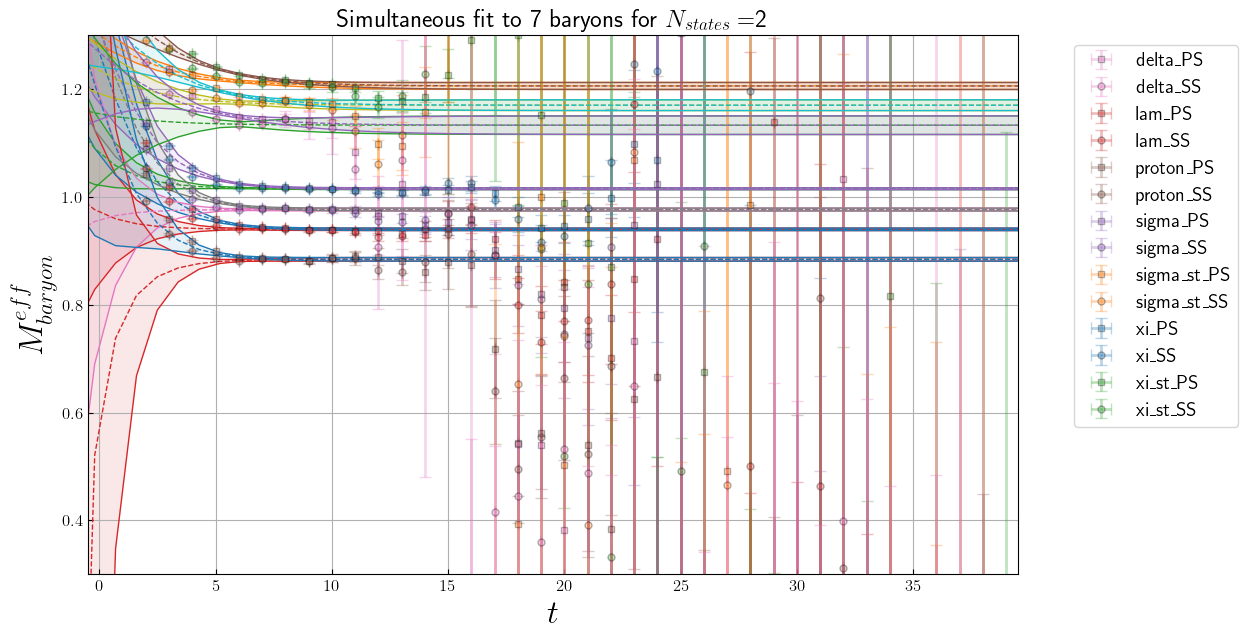

'0.8844(34) & 1.0154(18) & 0.9767(27) & 0.9400(23) & 1.2060(65) & 1.133(17) & 1.170(10) '

In [5]:
from tabulate import tabulate
abbr = 'a15m400'
fit_params = os.path.join(input_dir, f"{abbr}.py")
hyperon_fit = fa.analyze_hyperon_corrs(data_file, fit_params, model_type=model_type,
                                               bs=False, bs_file=bs_data_file,
                                               bs_path=abbr, bs_N=bs_N, bs_seed=bs_seed)
   

my_fit = hyperon_fit.get_fit()
plot2 = hyperon_fit.plot_effective_mass(t_plot_min=t_plot_min, t_plot_max=t_plot_max, model_type=model_type,
                                           show_plot=True, show_fit=True)

from tabulate import tabulate

def generate_latex_line(hyperon_fit):
    ordered_keys = ['proton_E0', 'xi_E0', 'sigma_E0', 'lam_E0', 'xi_st_E0', 'delta_E0', 'sigma_st_E0']
    latex_line = ""

    for key in ordered_keys:
        if key in hyperon_fit.p:
            p = hyperon_fit.p[key]
            latex_line += f"{p} & "
        else:
            latex_line += "& "

    # Remove the last ampersand and space
    latex_line = latex_line[:-2]

    return latex_line


generate_latex_line(hyperon_fit=my_fit)


In [6]:
from tabulate import tabulate

abbreviations = [f[:-3] for f in os.listdir(input_dir) if f.endswith('.py')]

for abbr in abbreviations:
    fit_params = os.path.join(input_dir, f"{abbr}.py")
    if not os.path.exists(fit_params):
        print(f"Error: input file {fit_params} does not exist!")
        continue

    with open(fit_params, 'r') as f:
        input_file_contents = f.read()

    if 'p_dict' not in input_file_contents:
        print(f"Error: input file {fit_params} does not contain a dictionary called 'p_dict'!")
        continue

    try:
        p_dict = {}
        exec(input_file_contents, p_dict)
    except Exception as e:
        print(f"Error: Failed to execute the contents of input file {fit_params}!\n{str(e)}")
        continue

    if 'tag' not in p_dict:
        print(f"Warning: input file {fit_params} does not contain a dictionary called 'tag' within the 'p_dict' dictionary! Adding default values...")
        p_dict['tag'] = {
            'sigma' : 'sigma',
            'sigma_st' : 'sigma_st',
            'xi' :  'xi',
            'xi_st' : 'xi_st',
            'lam' : 'lam',
        }

    try:
        hyperon_fit = fa.analyze_hyperon_corrs(data_file, fit_params, model_type=model_type,
                                               bs=False, bs_file=bs_data_file,
                                               bs_path=abbr, bs_N=bs_N, bs_seed=bs_seed)
    except KeyError:
        print(f"KeyError: Error analyzing hyperons for input file {fit_params}. Skipping abbreviation {abbr}.")
        continue

    my_fit = hyperon_fit.get_fit()

    out_path = os.path.join(fit_results_dir, abbr, model_type)
    ld.pickle_out(fit_out=my_fit, out_path=out_path, species="hyperons")
    plot1 = hyperon_fit.return_best_fit_info()
    plot2 = hyperon_fit.plot_effective_mass(t_plot_min=t_plot_min, t_plot_max=t_plot_max, model_type=model_type,
                                            show_plot=True, show_fit=True)

    output_dir = os.path.join(fit_results_dir, abbr, f"{model_type}_{abbr}")
    os.makedirs(output_dir, exist_ok=True)
    output_pdf = os.path.join(output_dir, 'output.pdf')
    with PdfPages(output_pdf) as pp:
        pp.savefig(plot1)
        pp.savefig(plot2)

    params_df = pd.DataFrame(my_fit.p).transpose()

    print("Abbreviation:", abbr)
    print(tabulate(params_df, headers='keys', tablefmt='fancy_grid'))

    # Ask the user if the fit result is acceptable
    while True:
        result = input(f"Is the fit result for abbreviation {abbr} acceptable? (y/n): ")
        if result == "y":
            # Save the result and skip this fit in future runs
            out_path = 'fit_results/{0}/{1}/'.format(abbr, model_type)
            ld.pickle_out(fit_out=my_fit, out_path=out_path, species="hyperons")
            break
        elif result == "n":
            break
